# ADVANCED LEARNING FOR TEXT AND GRAPH DATA


## First thoughts: unsupervised keyword extraction

* This initial paper is meant to apply methods from __social network analysis__ to __word co_occurence networks__ to extract __keywords__. 
* Those same methods could be applied in many other fields such as music, chemistry and so on (_I will proceed on them if I got time_).
* But for now, let's focus on ___Unsupervised single-document keyword extraction___.
* The point of this paper is to see, if I really have understood the concepts be sharing it to others, if you notice any mistakes, please notify them :)

### Import

In [2]:
# conda install -c conda-forge python-igraph

In [3]:
import re 
import itertools
import operator
import copy
import igraph #  conda install -c conda-forge python-igraph
import heapq
import nltk
# requires nltk 3.2.1
from nltk import pos_tag # nltk.download('maxent_treebank_pos_tagger')

### Preprocessing

Before even starting to make graphs of word co_occurence networks, we have to clean up the input texts. Let me remind you the steps :
* __convert to lower case__
* __remove any punctuation__
* __tokenize__
* __remove stopwords__ –_Those are the words that occurs often and adds no useful meaning to a sentence, such as  "the, is, at, which, and on"_–
- __pos filtering__ –_get only nouns and adjective_– :  part-of-speech tagging is also called grammatical tagging or word-category.
- __stem__: likely, likes, liking ==> like

In [4]:
def clean_text_simple(text, my_stopwords, punct, remove_stopwords=True, pos_filtering=True, stemming=True):
    
    text = text.lower()
    text = ''.join(l for l in text if l not in punct) # remove punctuation (preserving intra-word dashes)
    text = re.sub(' +',' ',text) # strip extra white space
    text = text.strip() # strip leading and trailing white space
    tokens = text.split(' ') # tokenize (split based on whitespace)
    if pos_filtering == True:
        # POS-tag and retain only nouns and adjectives
        tagged_tokens = pos_tag(tokens)
        tokens_keep = []
        for item in tagged_tokens:
            if (
            item[1] == 'NN' or
            item[1] == 'NNS' or
            item[1] == 'NNP' or
            item[1] == 'NNPS' or
            item[1] == 'JJ' or
            item[1] == 'JJS' or
            item[1] == 'JJR'
            ):
                tokens_keep.append(item[0])
        tokens = tokens_keep
    if remove_stopwords:
        tokens = [token for token in tokens if token not in my_stopwords]
    if stemming:
        stemmer = nltk.stem.PorterStemmer()
        tokens_stemmed = list()
        for token in tokens:
            tokens_stemmed.append(stemmer.stem(token))
        tokens = tokens_stemmed
    
    return(tokens)

### Word co-occurrence networks

Let's modelize the graph of words by __the distributional hypothesis__. This means that we know a word according to its neighbours. In order not to make the graph to dense, we will cut the sentence into chunks. This chunks will be browsed one by one by a window. 
<br><br>
Each term will be symbolized as a node, and the if they co-occur within a windows they will be linked with an edge. The edges can be weighted, it's the count of the co-occurence. Therefore, in this model, we have word dependency and even terms order if the graph has directed edges.
<br><br> Let's transform text into a graph:

In [5]:
def terms_to_graph(terms, window_size):

    from_to = {}

    w = min(window_size, len(terms))
    # create initial complete graph (first w terms)
    terms_temp = terms[0:w]
    indexes = list(itertools.combinations(range(w), r=2))

    new_edges = []

    for my_tuple in indexes:
        new_edges.append(tuple([terms_temp[i] for i in my_tuple]))
    for new_edge in new_edges:
        if new_edge in from_to:
            from_to[new_edge] += 1
        else:
            from_to[new_edge] = 1

    # then iterate over the remaining terms
    for i in range(w, len(terms)):
        # term to consider
        considered_term = terms[i]
        # all terms within sliding window
        terms_temp = terms[(i - w + 1):(i + 1)]

        # edges to try
        candidate_edges = []
        for p in range(w - 1):
            candidate_edges.append((terms_temp[p], considered_term))

        for try_edge in candidate_edges:

            # if not self-edge
            if try_edge[1] != try_edge[0]:

                # if edge has already been seen, update its weight
                if try_edge in from_to:
                    from_to[try_edge] += 1

                # if edge has never been seen, create it and assign it a unit weight
                else:
                    from_to[try_edge] = 1

    # create empty graph
    g = igraph.Graph(directed=True)

    # add vertices
    g.add_vertices(sorted(set(terms)))

    # add edges, direction is preserved since the graph is directed
    g.add_edges(list(from_to.keys()))

    # set edge and vertice weights
    g.es['weight'] = list(from_to.values()) # based on co-occurence within sliding window
    g.vs['weight'] = g.strength(weights=list(from_to.values())) # weighted degree

    return (g)

In [27]:
import string
import matplotlib.pyplot as plt  
from nltk.corpus import stopwords


stpwds = stopwords.words('english')
#stpwds = stopwords.words('french')
punct = string.punctuation.replace('-', '')
my_doc = "Mithuran loves Chloe and she loves Quentin. However, Quentin loves Mithuran. Mithuran is sad"
my_doc = "TOTO is a trader man. TOTO is a boss of Google. He plays Tennis"

#my_doc = "Mithuran is married to Marion but he loves Chloé. Unfortunately, Chloé loves Quentin. The tricky part is that Quentin loves Marion. What a mess"
#my_doc = "Mithuran aime Chloé et elle aime Quentin. Quentin aime Mithuran."
my_doc = my_doc.replace('\n', '')



In [7]:
# nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/raphael/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [28]:
# pre-process document
my_tokens = clean_text_simple(my_doc,my_stopwords=stpwds,punct=punct)

g = terms_to_graph(my_tokens, 2)

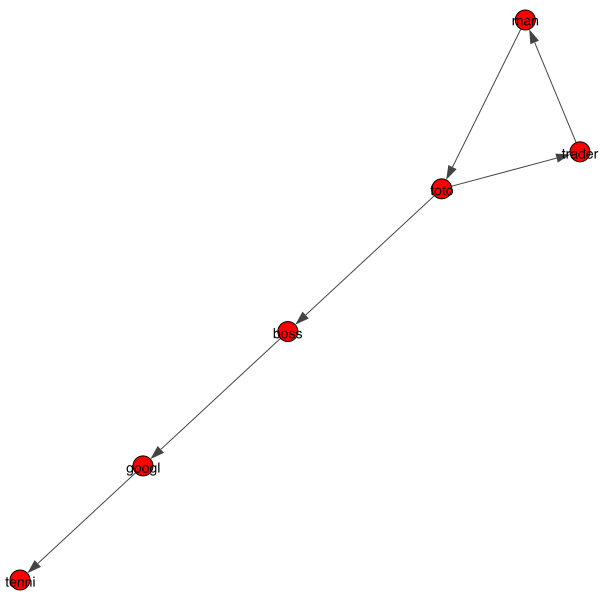

In [29]:
g.vs["label"] = g.vs["name"]
igraph.plot(g)

* Try both langages. We observe that french works less well: this is due to the stemmer, it transformed "aime" into "aim", it's therefore not recognising it as a verb. This can be changed in the nltk language import at the beginning.
* Playing with the windows size is fun ! The density of the graph changes totally while the number of nodes is constant !

### Keyword Extraction by Graph degeneneracy

* Now we are able to clean, process the text into a graph, we can finally start applying social network methods on words network.
* Let's do the analogy. In social network, the nodes are representeds by people, and edges as their link. It's known during preious studies, that a person with less friends but in the core of a part of the network will help diffuse the informations. On the othe rhand, words are nodes and their co-occurence are the edges, meaning that some words would be able to influence on other. 
* So what should one think ? One has to find the core of sub networks. This is easy because  B.Seidman . in 1983, released a book, named Network structure and minimum degree where he explains the K-core algorithm.

Rather than explaining what is K-core decomposition, I will let you have a look at this short video:
https://www.youtube.com/watch?v=rHVrgbc_3JA
<br><br>
Now, this is what we call unweighted k-core. In short, we remove the the lowest degree node at each step where degree is the number of immediate neighbors. If the graph is weighted, the degree should be assumed as the sum of the co-occurences, meaning that if we are trying to prune a node, we will be looking at this definition of the degreee : "the wors that appears the least".








In [30]:
def core_dec(g,weighted):
    '''(un)weighted k-core decomposition'''
    # work on clone of g to preserve g 
    gg = copy.deepcopy(g)
    if not weighted:
        gg.vs['weight'] = gg.strength() # overwrite the 'weight' vertex attribute with the unweighted degrees
    # initialize dictionary that will contain the core numbers
    cores_g = dict(zip(gg.vs['name'],[0]*len(gg.vs)))
    
    while len(gg.vs) > 0:
        # find index of lowest degree vertex
        min_degree = min(gg.vs['weight'])
        index_top = gg.vs['weight'].index(min_degree)
        name_top = gg.vs[index_top]['name']
        # get names of its neighbors
        neighbors = gg.vs[gg.neighbors(index_top)]['name']
        # exclude self-edges
        neighbors = [elt for elt in neighbors if elt!=name_top]
        # set core number of lowest degree vertex as its degree
        cores_g[name_top] = min_degree
        # delete top vertex and its incident edges
        gg.delete_vertices(index_top)
        
        if neighbors:
            if weighted: 
                new_degrees = gg.strength(weights=gg.es['weight'])
            else:
                new_degrees = gg.strength()
            # iterate over neighbors of top element
            for neigh in neighbors:
                index_n = gg.vs['name'].index(neigh)
                gg.vs[index_n]['weight'] = max(min_degree,new_degrees[index_n])  
        
    return(cores_g)

In [31]:
core_numbers = core_dec(g,False)
print("A comparison between our function and the built in function of igraph: ")
print(core_numbers)
print(dict(zip(g.vs['name'],g.coreness())))

A comparison between our function and the built in function of igraph: 
{'boss': 1.0, 'googl': 1.0, 'man': 2.0, 'tenni': 1.0, 'toto': 2.0, 'trader': 2.0}
{'boss': 1, 'googl': 1, 'man': 2, 'tenni': 1, 'toto': 2, 'trader': 2}


* Those values, represents the biggest core of our texts. 
* Those words are the most influential in our model.
* In other words, those are the keywords of the previous text.

SO here you are :D. You got a keyword extractor using a simple graph model.<br>
There is so many ways to use it: finding music tonality, detecting event that are happening thanks to tweets and so on.<br>
If you have any other ideas, please feel free to comment, add changes and contact me ! I'm still learning. I hope that you enjoyed this brief work.

The edges fails to explain the nature of relation ships within words. Intuitively, I would say that word are connected through verbs. Could it be interesting to modelise those verbs by embeddings ? Then, by minimizing the error we would be able to get a lexical range of word that explains the nature of the relationship between the words. 